In [1]:
import array
import random
import time

import numpy as np

from deap import algorithms
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
#@title ES Bounding Hyperparameters
IND_SIZE = 6
NGEN = 1000
MIN_VALUE = 4
MAX_VALUE = 5
MIN_STRATEGY = 0.5
MAX_STRATEGY = 3

CXPB = .6
MUTPB = .3
GEN_OUTPUT = 25
MAX_TIME = 5

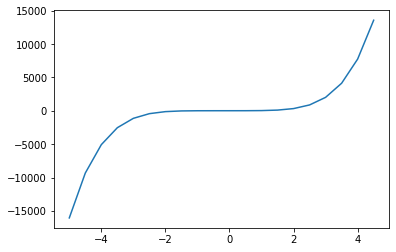

In [3]:
#@title Generate regression data
equation_form = "polynomial" #@param ["polynomial", "abs", "step"]

X_START = -5
X_END = 5
X_STEP = 0.5

def equation(x):
  if equation_form == "polynomial":
    return (2*x + 3*x**2 + 4*x**3 + 5*x**4 + 6*x**5 + 10)
  elif equation_form == "abs":
    return abs(x)
  else:
    return np.where(x>1, 1, 0)

X = np.array([x for x in np.arange(X_START, X_END, X_STEP)])
Y = equation(X)
data = list(zip(X, Y))

plt.plot(X,Y)

In [4]:
#@title Create the Creator
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", array.array, typecode="d", fitness=creator.FitnessMin, strategy=None)
creator.create("Strategy", array.array, typecode="d")

In [5]:
#@title Individual generator and decorate functions
def generateES(icls, scls, size, imin, imax, smin, smax):
  ind = icls(random.uniform(imin, imax) for _ in range(size))
  ind.strategy = scls(random.uniform(smin, smax) for _ in range(size))
  return ind

def checkStrategy(minstrategy):
  def decorator(func):
    def wrappper(*args, **kargs):
      children = func(*args, **kargs)
      for child in children:
        for i, s in enumerate(child.strategy):
          if s < minstrategy:
            child.strategy[i] = minstrategy
      return children
    return wrappper
  return decorator

In [6]:
#@title Setup the Toolbox
print(checkStrategy(MIN_STRATEGY))
toolbox = base.Toolbox()
toolbox.register("individual", generateES, creator.Individual, creator.Strategy,
    IND_SIZE, MIN_VALUE, MAX_VALUE, MIN_STRATEGY, MAX_STRATEGY)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxESBlend, alpha=0.1)
toolbox.register("mutate", tools.mutESLogNormal, c=1.0, indpb=0.03)
toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.decorate("mate", checkStrategy(MIN_STRATEGY))
toolbox.decorate("mutate", checkStrategy(MIN_STRATEGY))

<function checkStrategy.<locals>.decorator at 0x10ec35f70>


In [7]:
#@title Evaluation of fitness
def pred(ind, x):
  y_ = 0.0
  for i in range(1,IND_SIZE):
    y_ += ind[i-1]*x**i
  y_ += ind[IND_SIZE-1]
  return y_

def fitness(ind, data):
  mse = 0.0
  for x, y in data:
    y_ = pred(ind, x)
    mse += (y - y_)**2
  return mse/len(data),

# fitness eval
toolbox.register("evaluate", fitness, data=data)

In [8]:
#@title Plot Fitness
def plot_fitness(g, best, pop, logbook):
  Y_ = np.array([pred(best, x) for x in X])
  clear_output()
  best = [round(b,1) for b in best]
  print(f"Generation {g}, Best {best}")
  print(logbook.stream)
  fits = [f.fitness.values[0] for f in pop]
  plt.hist(fits)
  plt.show()
  plt.scatter(X,Y)
  plt.plot(X,Y_, 'r')
  plt.show()

Generation 99, Best [2.7, 4.3, 4.0, 4.9, 6.0, 6.8]
gen	nevals	avg    	std       	min    	max    
0  	0     	8.89512	0.00124024	8.89244	8.90194
1  	892   	8.91306	0.297534  	8.89162	13.608 


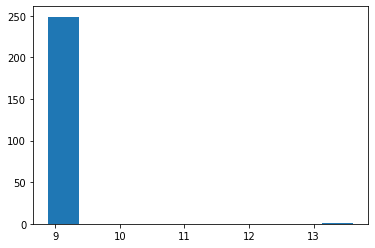

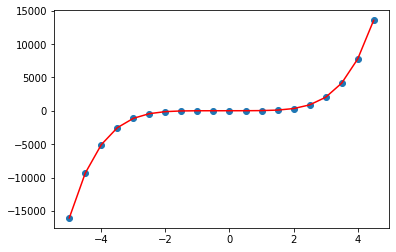

Best individual is  [2.7, 4.3, 4.0, 4.9, 6.0, 6.8] 8.88


In [9]:
#@title Run the Evolution
random.seed(64)

MU, LAMBDA = 250, 1000
pop = toolbox.population(n=MU)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

start = time.time()
for g in range(NGEN):
  pop, logbook = algorithms.eaMuCommaLambda(pop, toolbox, mu=MU, lambda_=LAMBDA,
            cxpb=CXPB, mutpb=MUTPB, ngen=1, stats=stats, halloffame=hof, verbose=False)
  if (g+1) % GEN_OUTPUT == 0:
    plot_fitness(g, hof[0], pop, logbook)
    end = time.time()
    if end-start > MAX_TIME:
      break

best = [round(i,1) for i in hof[0]]
print("Best individual is ", best, round(hof[0].fitness.values[0],2))